In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn import pipeline, preprocessing, compose, linear_model, impute, model_selection

In [2]:
df = pd.read_csv("/data/insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
target = "charges"
y = np.log10(df[target])
X = df.drop(columns=[target])

In [4]:
cat_columns = ["gender", "smoker", "region"]
num_columns = ["age", "bmi", "children"]

In [5]:
cat_pipe = pipeline.Pipeline([
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='error', drop="first"))
]) 

num_pipe = pipeline.Pipeline([
    ('imputer', impute.SimpleImputer(strategy='median')),
    ('poly', preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', preprocessing.StandardScaler()),
])

preprocessing_pipe = compose.ColumnTransformer([
    ("cat", cat_pipe, cat_columns),
    ("num", num_pipe, num_columns)
])


estimator_pipe = pipeline.Pipeline([
    ("preprocessing", preprocessing_pipe),
    ("est", linear_model.ElasticNet(random_state=1))
])


param_grid = {
    "est__alpha": 0.0 + np.random.random(10) * 0.02,
    "est__l1_ratio": np.linspace(0.0001, 1, 20),
}


gsearch = model_selection.GridSearchCV(estimator_pipe, param_grid, cv = 5, verbose=1, n_jobs=8)

gsearch.fit(X, y)

print(gsearch.best_score_, gsearch.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s


0.770262430686041 {'est__alpha': 0.0031165818915127952, 'est__l1_ratio': 0.0001}


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    4.1s finished


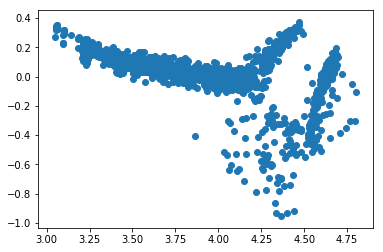

In [6]:
y_pred = gsearch.predict(X)
plt.scatter(y, y_pred - y)

In [7]:
pd.DataFrame({"actual": y, "predict": y_pred}).sample(10)

,actual,predict
696,4.465182,4.114349
675,3.858705,3.797295
56,4.133774,4.168367
146,4.609814,4.641106
938,3.362483,3.514658
165,4.017329,4.003195
856,4.612510,4.587986
1135,4.044759,4.034695
130,4.107734,4.112852
933,3.866178,3.893529


In [8]:
with open("/tmp/model.pickle", "wb") as f:
    pickle.dump(gsearch, f)

In [1]:
import pickle
import pandas as pd
with open("/tmp/model.pickle", "rb") as f:
    est = pickle.load(f)

In [10]:
est.score(X, y)

0.7760059364331596

In [2]:
record = {"age": 18, "gender": "male", "bmi": 33.0, "smoker": "no", "children": 1, "region": "southeast"}
record

{'age': 18,
 'gender': 'male',
 'bmi': 33.0,
 'smoker': 'no',
 'children': 1,
 'region': 'southeast'}

In [3]:
df_input = pd.DataFrame.from_dict([record])
10 ** est.predict(df_input)

array([3028.82314557])